In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import seaborn as sns


# Train data analysis - single dim

In [2]:
train_data = dict()

envs = ['halfcheetah', 'hopper', 'walker2d']
datasets = ['expert', 'medium_replay', 'medium']

for e in envs:
    for d in datasets:
        with open(f'./data_plus_plus/{e}-{d}-v2.pkl', 'rb') as f:
            train_data[f'{e}-{d}'] = pickle.load(f)

In [3]:
idxs = [f'{e}-{d}' for e in envs for d in datasets]
df_train_data = pd.DataFrame(index=idxs)

df_train_data['mean_terminals'] = [np.mean([sum(data['terminals']) for data in train_data[idx]]) for idx in idxs]
df_train_data['mean_total_reward'] = [np.mean([sum(data['rewards']) for data in train_data[idx]]) for idx in idxs]
df_train_data['std_terminal_reward'] = [np.std([sum(data['rewards']) for data in train_data[idx]]) for idx in idxs]
df_train_data['n_traj'] = [len(train_data[idx]) for idx in idxs]

In [4]:
from sklearn.linear_model import LinearRegression


def get_forward_reward(positions):
    return positions[1:] - positions[:-1]


def get_control_cost(actions):
    return np.sum(np.square(actions), axis=1)


# calculate the weights of the individual parts of the reward using linear regression
def get_coef(data_temp, use_healthy_reward=False):

    forward_reward = get_forward_reward(data_temp['infos/qpos'][:,0])
    ctrl_cost = get_control_cost(data_temp['actions'])

    target_reward = data_temp['rewards'][:-1]

    if use_healthy_reward:
        healthy_reward = np.array(~data_temp['terminals'], dtype=int)
        X = np.stack((forward_reward, ctrl_cost[:-1], healthy_reward[:-1]), axis=0).T
    else:
        X = np.stack((forward_reward, ctrl_cost[:-1]), axis=0).T

    reg = LinearRegression(fit_intercept=False).fit(X, target_reward)
    
    return reg, X, target_reward


In [5]:
all_r_scores, all_coefs, all_traj_lens = [], [], []
# no_weight_all_r_scores, no_weight_all_coefs = [], []

for idx in idxs:
    trajs = train_data[idx]

    use_healthy_reward = idx.split('-')[0] != 'halfcheetah'

    r_scores, coefs, total_traj_len = [], [], 0
    no_weight_r_scores, no_weight_coefs = [], []
    for traj in trajs:
        
        traj_len = len(traj['rewards'])
        if 2 < traj_len:
            reg, X, target_reward = get_coef(traj, use_healthy_reward=use_healthy_reward)

            total_traj_len += traj_len
            r_scores.append(traj_len * reg.score(X, target_reward))
            coefs.append(traj_len * reg.coef_)

            # no_weight_r_scores.append(reg.score(X, target_reward))
            # no_weight_coefs.append(reg.coef_)
    
    all_traj_lens.append(total_traj_len)
    all_r_scores.append(r_scores)
    all_coefs.append(coefs)

    # no_weight_all_r_scores.append(no_weight_r_scores)
    # no_weight_all_coefs.append(no_weight_coefs)

all_traj_lens = np.array(all_traj_lens)
df_train_data['r_scores'] = np.array([np.sum(arr) for arr in all_r_scores]) / all_traj_lens
df_train_data['coefs'] = [np.array(arr).sum(axis=0) / traj_len for arr, traj_len in zip(all_coefs, all_traj_lens)]



In [6]:
df_train_data

,mean_terminals,mean_total_reward,std_terminal_reward,n_traj,r_scores,coefs
halfcheetah-expert,0.000000,10656.426460,441.682728,1000,1.000000,"[19.999999996477182, -0.09999999924186359]"
halfcheetah-medium_replay,0.000000,3093.285581,1680.693937,202,1.000000,"[19.999999995244558, -0.09999999976999702]"
halfcheetah-medium,0.000000,4770.334765,355.750394,1000,1.000000,"[19.999999997876596, -0.09999999970695984]"
hopper-expert,0.086660,3511.357707,328.585955,1027,0.999986,"[125.01774816783156, -0.0015660894490739843, 1..."
hopper-medium_replay,0.803038,467.302044,511.025583,2041,0.999958,"[124.9811147564266, -0.0011514301893974356, 1...."
hopper-medium,0.999543,1422.056180,378.953696,2186,0.999976,"[124.95893755143503, -0.0013506799651984646, 1..."
walker2d-expert,0.001000,4920.507113,136.394925,1000,0.999573,"[125.05968093735972, -0.0010128432916729198, 1..."
walker2d-medium_replay,0.723696,682.701247,895.955582,1093,0.999040,"[124.69361385928454, -0.0009549325751498699, 0..."
walker2d-medium,0.431092,2852.088416,1095.443313,1190,0.999261,"[124.8290256667378, -0.0009880693215550231, 0...."


# Train data analysis - multi dim

In [7]:
split_data = dict()

envs = ['halfcheetah', 'hopper', 'walker2d']
datasets = ['expert', 'medium_replay', 'medium']

for e in envs:
    for d in datasets:
        with open(f'./data_split_reward/{e}-{d}-v2.pkl', 'rb') as f:
            split_data[f'{e}-{d}'] = pickle.load(f)

In [8]:
idxs = [f'{e}-{d}' for e in envs for d in datasets]

df_split_data = pd.DataFrame(index=idxs)
df_split_data['mean_forward_reward'] = [np.mean([sum(data['multi_rewards'][0]) for data in split_data[idx]]) for idx in idxs]
df_split_data['max_forward_reward'] = [np.max([sum(data['multi_rewards'][0]) for data in split_data[idx]]) for idx in idxs]
df_split_data['std_forward_reward'] = [np.std([sum(data['multi_rewards'][0]) for data in split_data[idx]]) for idx in idxs]

df_split_data['mean_ctrl_cost'] = [np.mean([sum(data['multi_rewards'][1]) for data in split_data[idx]]) for idx in idxs]
df_split_data['max_ctrl_cost'] = [np.max([sum(data['multi_rewards'][1]) for data in split_data[idx]]) for idx in idxs]
df_split_data['std_ctrl_cost'] = [np.std([sum(data['multi_rewards'][1]) for data in split_data[idx]]) for idx in idxs]


In [9]:
df_split_data

,mean_forward_reward,max_forward_reward,std_forward_reward,mean_ctrl_cost,max_ctrl_cost,std_ctrl_cost
halfcheetah-expert,10989.591014,11586.565315,445.307242,344.516035,353.562531,5.528283
halfcheetah-medium_replay,3462.835824,5358.871842,1703.726608,372.415731,521.301525,45.833993
halfcheetah-medium,5151.688493,5694.790690,365.368916,386.243117,395.998188,11.156299
hopper-expert,2536.375363,2756.266925,232.199838,1.079829,1.157054,0.109320
hopper-medium_replay,268.992758,2192.641641,341.634900,0.264751,1.853993,0.263971
hopper-medium,962.549354,2221.311054,269.081605,0.572650,1.321390,0.155059
walker2d-expert,3917.864108,4008.154703,112.564518,2.971940,3.198631,0.083525
walker2d-medium_replay,406.121699,3129.280744,656.273649,0.819277,3.872965,0.843474
walker2d-medium,2011.421483,3230.664397,931.954885,2.596812,3.606782,0.761491


In [10]:
print(split_data.keys())
print(len(split_data['halfcheetah-expert']))
print(split_data['halfcheetah-expert'][0].keys())
print(split_data['halfcheetah-expert'][0]['multi_rewards'].shape)

dict_keys(['halfcheetah-expert', 'halfcheetah-medium_replay', 'halfcheetah-medium', 'hopper-expert', 'hopper-medium_replay', 'hopper-medium', 'walker2d-expert', 'walker2d-medium_replay', 'walker2d-medium'])
1000
dict_keys(['observations', 'next_observations', 'actions', 'rewards', 'terminals', 'infos/qpos', 'infos/qvel', 'multi_rewards'])
(2, 999)


In [11]:
split_data['halfcheetah-expert'][0]['multi_rewards'].sum(axis=1)

array([11094.32599203,   344.89803379])

In [12]:
df_list = []
for env_data, trajectories in split_data.items():
    env_name, dataset = env_data.split('-')
    forward_rewards, ctrl_costs = np.array([traj['multi_rewards'].sum(axis=1) for traj in trajectories]).T
    
    data_dict = {'env_name': env_name, 'dataset': dataset, 'forward_reward': forward_rewards, 'ctrl_cost': ctrl_costs}
    df_list.append(pd.DataFrame.from_dict(data_dict))

df_multi_reward = pd.concat(df_list, ignore_index=True)

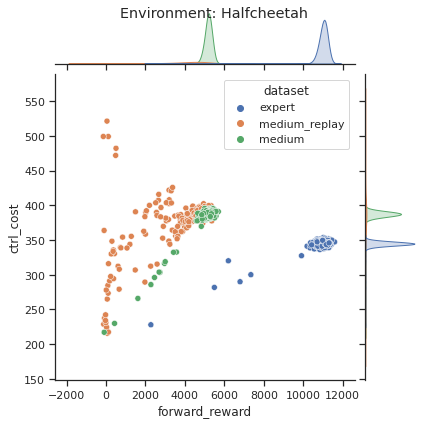

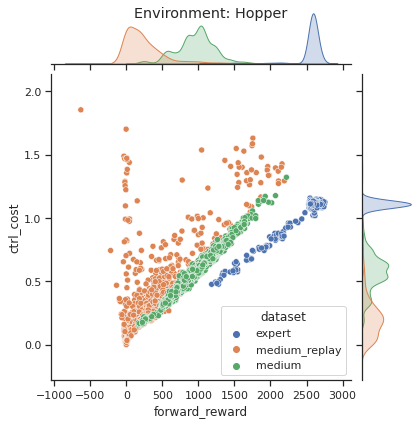

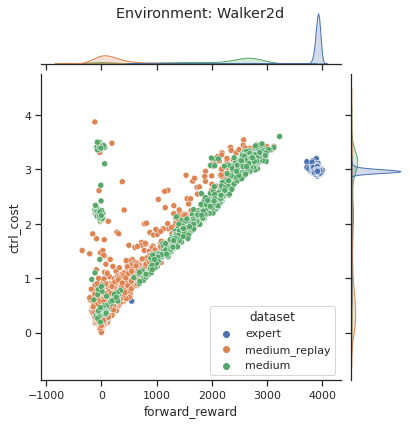

In [13]:
sns.set_theme(style="ticks")

env_name = 'halfcheetah'
dataset = 'medium_replay'

# Show the joint distribution using kernel density estimation
for env_name in envs:

    data = df_multi_reward[ (df_multi_reward['env_name'] == env_name) ] # & (df_multi_reward['dataset'] == dataset)

    g = sns.jointplot(
        data=data,
        x='forward_reward', y='ctrl_cost', hue='dataset'
    )
    
    plt.suptitle(f'Environment: {env_name.capitalize()}')

# Do fit on right coefs

# fitting model to data

[ 1.25021335e+02 -1.59924108e-03  1.00001544e+00] 0.9999871383523756


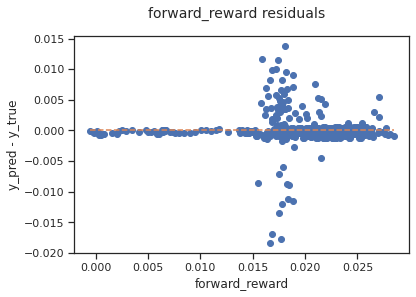

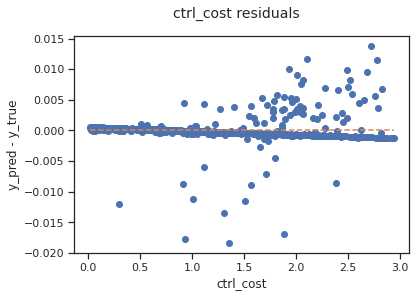

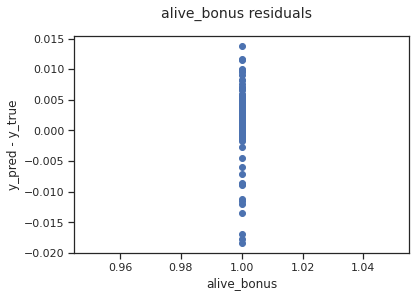

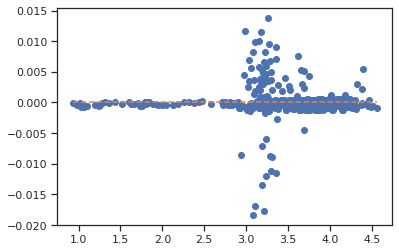

In [14]:
# half cheetah

# choose dataset
data_temp = train_data['hopper-expert'][0]
reg, X, target_reward = get_coef(data_temp, use_healthy_reward=True)
print(reg.coef_, reg.score(X, target_reward))

predictions = reg.predict(X)

names = ["forward_reward", "ctrl_cost", "alive_bonus"]
for i, (X_1dim, name) in enumerate(zip(X.T, names)):
    fig, ax = plt.subplots()
    ax.set_xlabel(name)
    ax.set_ylabel("y_pred - y_true")
    plt.suptitle(f"{name} residuals", size=14)
    plt.scatter(X_1dim, predictions - target_reward, c='C0')
    plt.hlines(0, min(X_1dim), max(X_1dim), linestyles='--', colors='C1')
    plt.show()


plt.scatter(predictions, predictions - target_reward, c='C0')
plt.hlines(0, min(predictions), max(predictions), linestyles='--', colors='C1')
plt.show()

# Data dist plots

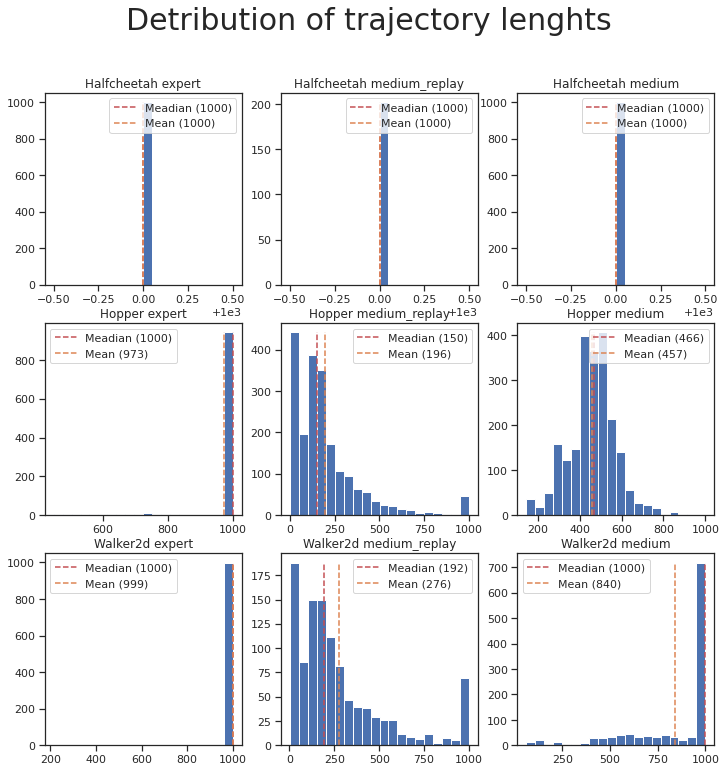

In [15]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12)) # note that halfcheetah does not terminate early, has no "survive" feature
fig.suptitle('Detribution of trajectory lenghts', size=30)

for ax, (key, data) in zip(axs.flatten(), train_data.items()):
    env, dataset = key.split('-')
    lengths = [len(data['rewards']) for data in train_data[key]]
    ax.set_title(f"{env.capitalize()} {dataset}")
    n, bins, _ = ax.hist(lengths, bins=20)

    median_val = np.median(lengths)
    ax.vlines(median_val, 0, max(n), linestyles='--', colors='C3', label=f'Meadian ({int(median_val)})')
    
    mean_val = np.mean(lengths)
    ax.vlines(mean_val, 0, max(n), linestyles='--', colors='C1', label=f'Mean ({int(mean_val)})')

    ax.legend()

plt.show()

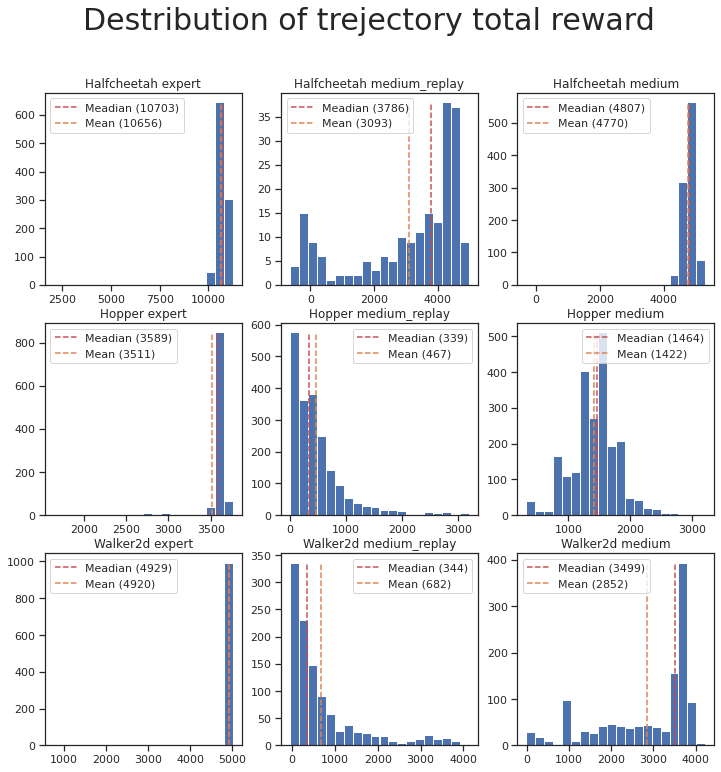

In [16]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Destribution of trejectory total reward', size=30)

for ax, (key, data) in zip(axs.flatten(), train_data.items()):
    env, dataset = key.split('-')
    terminal_rewards = [sum(data['rewards']) for data in train_data[key]]
    ax.set_title(f"{env.capitalize()} {dataset}")
    n, bins, _ = ax.hist(terminal_rewards, bins=20)

    median_val = np.median(terminal_rewards)
    ax.vlines(median_val, 0, max(n), linestyles='--', colors='C3', label=f'Meadian ({int(median_val)})')
    
    mean_val = np.mean(terminal_rewards)
    ax.vlines(mean_val, 0, max(n), linestyles='--', colors='C1', label=f'Mean ({int(mean_val)})')

    ax.legend()

plt.show()

# Evaluation analysis

In [17]:
eval_path = './evaluation_data/'
raw_eval_dict = dict()

for env in envs:

    eval_path_env = eval_path + env + '/'
    for dataset in datasets:
        
        eval_path_data = eval_path_env + dataset + '/'
        for filename in os.listdir(eval_path_data):
            with open(eval_path_data + filename, 'rb') as f:
                raw_eval_dict[filename] = pickle.load(f)

In [18]:
def read_data_to_DataFrama(raw_dict):

    return_keys = [key for key in raw_dict.keys() if '_returns' in key]
    temp_dict = dict()
    for key in return_keys:
        target_return, _ = key.split('_')
        if ' ' in target_return:
            target_return = tuple([float(e) for e in target_return[1:-1].split(' ') if e != ''])
            temp_dict[target_return] = list(map(np.array, raw_dict[key]))
        else:
            target_return = float(target_return)
            temp_dict[target_return] = raw_dict[key]
    
    return pd.DataFrame(temp_dict)


def get_plot_statistics(df, conf_int=(0.05, 0.95)):

    target_rewards = df.columns.to_numpy()
    reward_mean = df.to_numpy().mean(axis=0)
    reward_median = np.quantile(df.to_numpy(), 0.5, axis=0)
    # reward_std = df.to_numpy().std(axis=0)
    q_low, q_high = np.quantile(df.to_numpy(), conf_int, axis=0)

    return target_rewards, reward_mean, reward_median, q_low, q_high


eval_dict = {k.split('.')[0]: read_data_to_DataFrama(v) for k, v in raw_eval_dict.items()}

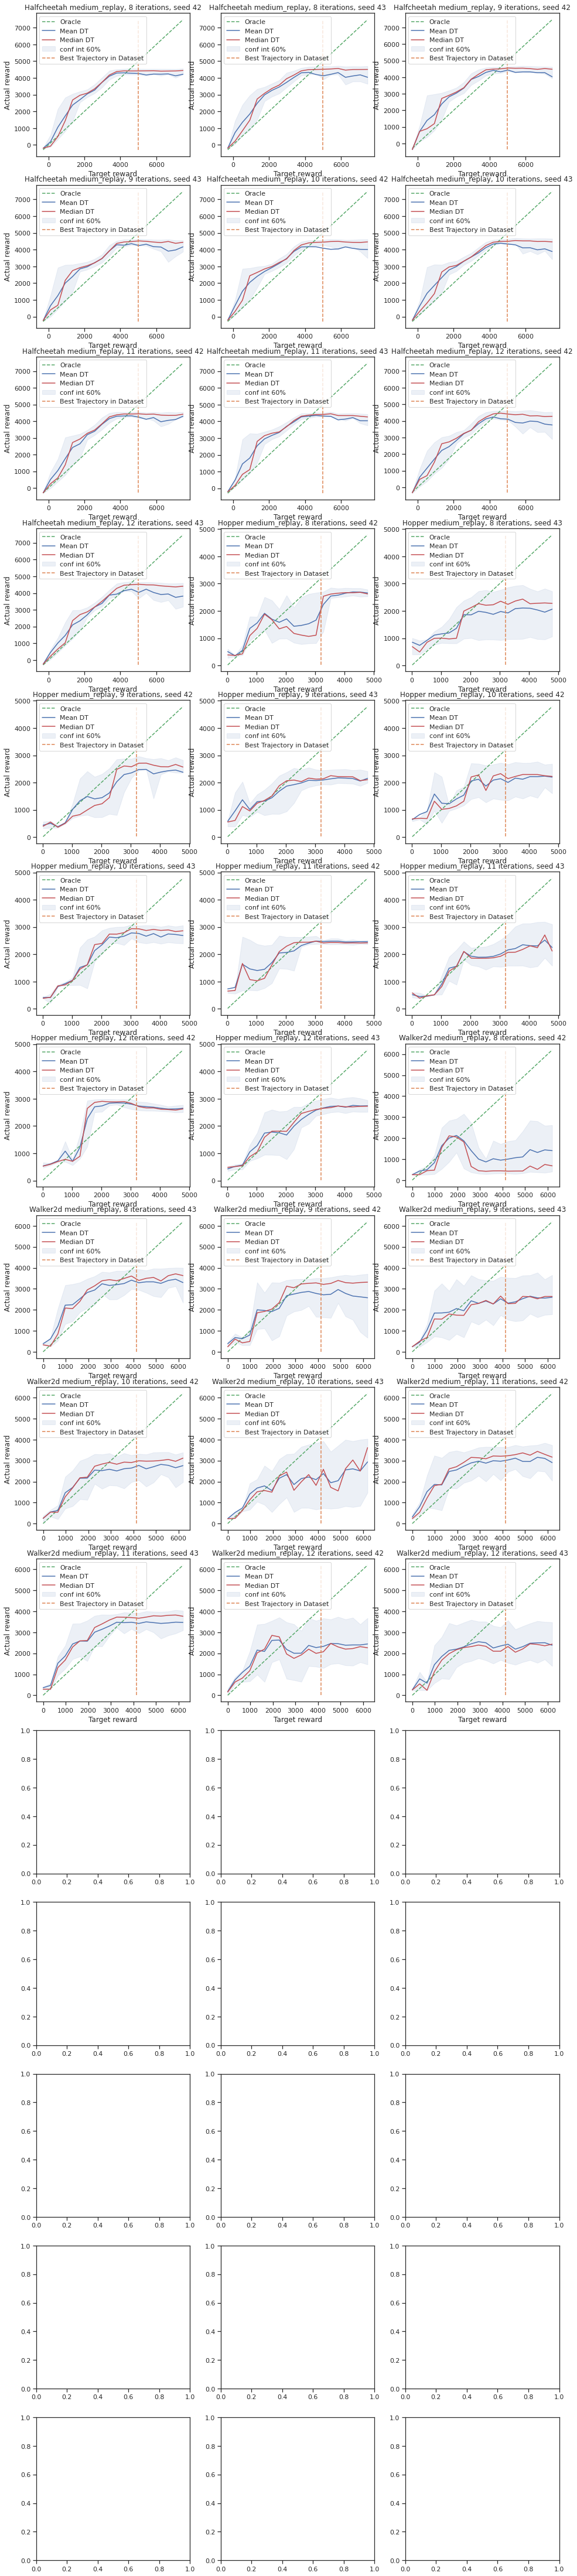

In [20]:
from itertools import product

seeds = range(42,44)
iters = range(8,13)
datasets = ['medium_replay']
env_names = ['halfcheetah', 'hopper', 'walker2d']
conf_int = (0.2, 0.8)

shape = (3,15) # set to none to calculate auto



filtered_keys = [f'iter{iter}-gym-experiment-{env}-{data}-{seed}' for env, data, iter, seed in product(env_names, datasets, iters, seeds)]

if shape is None:
    side_len = int(np.ceil(np.sqrt(len(filtered_keys))))
    shape = (side_len, side_len)

fig, axs = plt.subplots(shape[1], shape[0], figsize=(shape[0] * 16 / 3, shape[1] * 16 / 3))

for ax, exp_name in zip(axs.flatten(), filtered_keys):

    values = get_plot_statistics(eval_dict[exp_name], conf_int=conf_int)

    x, y_mean, y_median, q_low, q_high = values

    x_linear = np.linspace(min(x), max(x))
    ax.plot(x_linear, x_linear, '--', c='C2', label='Oracle')
    ax.plot(x, y_mean, c='C0', label='Mean DT')
    ax.plot(x, y_median, c='C3', label='Median DT')
    ax.fill_between(x, q_low, q_high, color='b', alpha=.1, label=f'conf int {int((conf_int[1]-conf_int[0])*100)}%')

    train_data_name = '-'.join(np.take(exp_name.split('-'), (3,4)))
    terminal_rewards = [sum(data['rewards']) for data in train_data[train_data_name]]
    ax.vlines(max(terminal_rewards), min(min(y_mean), min(x_linear)),
        max(max(y_mean), max(x_linear)), linestyles='--', colors='C1', label='Best Trajectory in Dataset')

    iter_name, _, _, env_name, data_name, seed = exp_name.split('-')
    ax.set_title(f"{env_name.capitalize()} {data_name}, {iter_name[4:]} iterations, seed {seed}" )
    ax.legend(loc="upper left")
    ax.set_xlabel('Target reward')
    ax.set_ylabel('Actual reward')

plt.show()


In [24]:
[e for e in eval_dict.keys() if '_multi' in e]

['iter8-gym-experiment_multi-halfcheetah-medium_replay-42',
 'iter1-gym-experiment_multi-halfcheetah-medium_replay-42069',
 'iter8-gym-experiment_multi-halfcheetah-medium_replay-43',
 'iter9-gym-experiment_multi-halfcheetah-medium_replay-42',
 'iter9-gym-experiment_multi-halfcheetah-medium_replay-43',
 'iter12-gym-experiment_multi-hopper-medium_replay-42',
 'iter8-gym-experiment_multi-hopper-medium_replay-43',
 'iter10-gym-experiment_multi-hopper-medium_replay-42',
 'iter12-gym-experiment_multi-hopper-medium_replay-43',
 'iter11-gym-experiment_multi-hopper-medium_replay-42',
 'iter11-gym-experiment_multi-hopper-medium_replay-43',
 'iter9-gym-experiment_multi-hopper-medium_replay-43',
 'iter9-gym-experiment_multi-hopper-medium_replay-42',
 'iter10-gym-experiment_multi-hopper-medium_replay-43',
 'iter9-gym-experiment_multi-hopper-medium_replay-44',
 'iter10-gym-experiment_multi-hopper-medium_replay-44',
 'iter8-gym-experiment_multi-hopper-medium_replay-42',
 'iter8-gym-experiment_multi-h

In [26]:
from itertools import product

seeds = [42,43, 44]
iters = [8, 9, 10, 11, 12]
datasets = ['medium_replay']
env_names = ['hopper', 'walker2d']

im_size = 6
head1_size = 22
head2_size = 17
head3_size = 15



filtered_keys = [f'iter{iter}-gym-experiment_multi-{env}-{data}-{seed}' for env, data, iter, seed in product(env_names, datasets, iters, seeds)]
shape = max(2, len(filtered_keys))

fig = plt.figure(figsize=(3 * im_size, shape * im_size), constrained_layout=True)
fig.suptitle('Multi reward', size=head1_size)


subfigs = fig.subfigures(nrows=shape, ncols=1)
for row, (exp_name, subfig) in enumerate(zip(filtered_keys, subfigs)):
    iter_name, _, _, env_name, data_name, seed = exp_name.split('-')
    subfig.suptitle(f"{env_name.capitalize()} {data_name}, {iter_name[4:]} iterations, seed {seed}", size=head2_size)

    ax_pair = subfig.subplots(nrows=1, ncols=3)

    df = eval_dict[exp_name]
    
    forward_vals, ctrl_vals = list(map(np.unique, np.array(list(map(list, df.columns))).T))

    forward_error = np.zeros((len(forward_vals), len(ctrl_vals)))
    ctrl_error = np.zeros((len(forward_vals), len(ctrl_vals)))
    reward_error = np.zeros((len(forward_vals), len(ctrl_vals)))

    for i_forward, forward_val in enumerate(forward_vals):
        for i_ctrl, ctrl_val in enumerate(ctrl_vals):
            # wierd data structure
            mean_forward, mean_ctrl = np.mean([e.sum(axis=0) for e in df[forward_val][ctrl_val].to_numpy()], axis=0)
            forward_error[i_ctrl, i_forward] = mean_forward - forward_val
            ctrl_error[i_ctrl, i_forward] = mean_ctrl - ctrl_val
            reward_error[i_ctrl, i_forward] = (mean_forward - mean_ctrl) - (forward_val - ctrl_val)

    rounder = lambda my_list, sig_difs: [float(f'%.{sig_difs}g' % e) for e in my_list]

    ax1, ax2, ax3 = ax_pair

    im1 = ax1.matshow(forward_error, cmap=plt.get_cmap('autumn'))
    ax1.set_title('forward_reward mean error', size=head3_size)
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.matshow(ctrl_error, cmap=plt.get_cmap('winter'))
    ax2.set_title('ctrl_cost mean error', size=head3_size)
    plt.colorbar(im2, ax=ax2)

    im3 = ax3.matshow(reward_error, cmap=plt.get_cmap('summer'))
    ax3.set_title('mean reward error', size=head3_size)
    plt.colorbar(im3, ax=ax3)

    for ax in ax_pair:
        ax.set_xlabel('target forward_reward')
        ax.set_ylabel('target ctrl_cost')
        
        x_ticks = rounder(forward_vals, 2)
        x_ticks = [x_ticks[int(tick_number)] for tick_number in ax.get_xticks() if tick_number < len(x_ticks)]
        ax.set_xticklabels(x_ticks)

        y_ticks = rounder(ctrl_vals, 2)
        y_ticks = [y_ticks[int(tick_number)] for tick_number in ax.get_yticks() if tick_number < len(y_ticks)]
        ax.set_yticklabels(y_ticks)

plt.show()


In [23]:
forward_error

array([[-1.91370096e+01, -9.01230490e+02, -1.79525583e+03,
        -2.68556118e+03, -3.58715878e+03, -4.47540328e+03,
        -5.37154364e+03, -6.24952826e+03, -7.15859862e+03,
        -8.04485020e+03],
       [-1.46448432e+01, -9.16623680e+02, -1.79712578e+03,
        -2.67475492e+03, -3.58285379e+03, -4.46846136e+03,
        -5.35262777e+03, -6.26443401e+03, -7.15116229e+03,
        -8.04041419e+03],
       [-4.75016213e+00, -8.94301166e+02, -1.79616146e+03,
        -2.67683886e+03, -3.57805558e+03, -4.46885144e+03,
        -5.36693413e+03, -6.26664006e+03, -7.15719181e+03,
        -8.03893924e+03],
       [-6.15974940e+00, -8.98561658e+02, -1.81242836e+03,
        -2.68031984e+03, -3.58364289e+03, -4.47494110e+03,
        -5.35908435e+03, -6.25599784e+03, -7.14921926e+03,
        -8.03556588e+03],
       [-1.08169369e+01, -9.18699939e+02, -1.79990231e+03,
        -2.69251990e+03, -3.58678678e+03, -4.47440557e+03,
        -5.39073607e+03, -6.25581536e+03, -7.14986886e+03,
        -8.